In [98]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
from tqdm import tqdm
from torch.nn import Parameter
from torch.nn.init import xavier_uniform_
import pandas as pd



%matplotlib inline

# import utility code
import mrnn_utility as mrnn_utility
from mrnn_utility import block_diag,unblock_diag, ReLU
#import MRNN.MRNN_model
#from MRNN.MRNN_model import MRNN
#from mrnn_utility import block_diag,unblock_diag

In [102]:


def live_plot(data,missing,ground_truth,figsize=(12,4), title=''):
    #clear_output(wait=True)
    plt.figure(figsize=figsize)
    #plt.ylim(-1.5,3.5)
    #plt.xlim(-2,51)
    missing=missing.cpu()
    x= np.arange(data.shape[1])
    colors=["blue","green","red", "yellow"]
    plot_num = 0
    if data.shape[0] > 4:
        plot_num = 4
    else:
        plot_num = data.shape[0]
    for dim in range(plot_num):
        plt.plot(x,data[dim].cpu(),c=colors[dim])
        plt.plot(x,ground_truth[dim].cpu(),alpha=0.5,linestyle="dashed",c=colors[dim])
        plt.scatter(x[missing[dim]],(data[dim][missing[dim]]).cpu(),c=colors[dim])

    line = Line2D([], [], label='ground truth', color='blue', linestyle="dashed")
    line2 = Line2D([], [], label='reconstruction', color='blue')
    line3 = Line2D([], [], label='missing points', color='blue',marker="o")
    
    plt.legend(handles=[line,line2,line3], numpoints=1,loc=3)
    plt.title("Epoch {}".format(int(title)+1))
#     plt.grid(True)
    plt.xlabel('axis x')
    plt.ylabel('axis y')
    plt.show()
    
def split_data(data, mask, delta):
    indices = np.arange(data.shape[0])
    np.random.shuffle(indices)
    train_indices= indices[:int(data.shape[0]*0.8)]
    test_indices = indices[int(data.shape[0]*0.8):]

    data_train = data[train_indices]
    mask_train = mask[train_indices]
    delta_train = delta[train_indices]
    data_test = data[test_indices]
    mask_test = mask[test_indices]
    delta_test = delta[test_indices]
    return data_train,mask_train,delta_train,data_test,mask_test,delta_test

def permute2st(v, ndim_en=1):
    """
    Permute last ndim_en of an array v to the first
    :type v: torch.Tensor
    :type ndim_en: int
    :rtype: torch.Tensor
    """
    nd = v.ndimension()
    return v.permute([*range(-ndim_en, 0)] + [*range(nd - ndim_en)])

def permute2en(v, ndim_st=1):
    """
    Permute first ndim_en of an array v to the last
    :type v: torch.Tensor
    :type ndim_st: int
    :rtype: torch.Tensor
    """
    nd = v.ndimension()
    return v.permute([*range(ndim_st, nd)] + [*range(ndim_st)])

def unblock_diag(m, n=None, size_block=None):
    """
    The inverse of block_diag(). Not vectorized yet.
    :param m: block diagonal matrix
    :param n: int. Number of blocks
    :size_block: torch.Size. Size of a block.
    :return: tensor unblocked such that the last sizes are [n] + size_block
    """
    # not vectorized yet
    if size_block is None:
        size_block = torch.Size(torch.tensor(m.shape[-2:]) // n)
    elif n is None:
        n = m.shape[-2] // torch.tensor(size_block[0])
        assert n == m.shape[-1] // torch.tensor(size_block[1])
        
    m = permute2st(m, 2)

    res = torch.zeros(torch.Size([n]) + size_block + m.shape[2:])
    for i_block in range(n):
        st_row = size_block[0] * i_block
        en_row = size_block[0] * (i_block + 1)
        st_col = size_block[1] * i_block
        en_col = size_block[1] * (i_block + 1)
        res[i_block,:] = m[st_row:en_row, st_col:en_col, :]

    return permute2en(res, 3)

def block_diag(m):
    """
    Make a block diagonal matrix along dim=-3
    EXAMPLE:
    block_diag(torch.ones(4,3,2))
    should give a 12 x 8 matrix with blocks of 3 x 2 ones.
    Prepend batch dimensions if needed.
    You can also give a list of matrices.
    :type m: torch.Tensor, list
    :rtype: torch.Tensor
    """
    if type(m) is list:
        m = torch.cat([m1.unsqueeze(-3) for m1 in m], -3)

    d = m.dim()
    n = m.shape[-3]
    siz0 = m.shape[:-3]
    siz1 = m.shape[-2:]
    m2 = m.unsqueeze(-2)
    eye = attach_dim(torch.eye(n).unsqueeze(-2), d - 3, 1)
    return (m2 * eye).reshape(
        siz0 + torch.Size(torch.tensor(siz1) * n)
    )

def attach_dim(v, n_dim_to_prepend=0, n_dim_to_append=0):
    return v.reshape(
        torch.Size([1] * n_dim_to_prepend)
        + v.shape
        + torch.Size([1] * n_dim_to_append))

def ReLU(x):
    return x * (x > 0)

def lin_interpolation(x_in):
    x = x_in.clone()
    for sample in range(x.shape[0]): # for every sample
        for stream in range(x.shape[1]): # for every stream
            s = pd.Series(x[sample,stream])
            s = s.interpolate().bfill().ffill() # linear interpolation, then backward and forward fill for first and last value
            x[sample,stream] = torch.tensor(s.values) # replace in original tensor
    return x

In [99]:
# Use cuda (GPU) to train models if available
if torch.cuda.is_available():
    device = torch.device('cuda')
    torch.set_default_dtype(torch.float32)
    torch.set_default_device(device)
else:
    device = torch.device('cpu')
    torch.set_default_dtype(torch.float32)
    

## M-RNN on small example

In [100]:
# Generate the dummy dataset
np.random.seed(123)
f = np.array([1.5,2,2.5])
offset = np.array([0,1,2]).reshape(-1,1)
w = 2. * np.pi * f
t = np.linspace(0, 1, 50)
x = torch.tensor(np.sin(w.reshape(-1,1) * t)+offset).float()
ground_truth = x.detach().clone()
mask = torch.ones_like(x)
delta = torch.ones_like(x).float()
delta[:,0] = 0

# remove 5% of the data
ix = [(channel,t) for channel in range(x.shape[0]) for t in range(x.shape[1])]
np.random.shuffle(ix)
to_replace = int(round(.05*len(ix)))
ix = ix[:to_replace]
for idx in ix:
    x[idx[0],idx[1]] = np.nan
    mask[idx[0],idx[1]] = 0

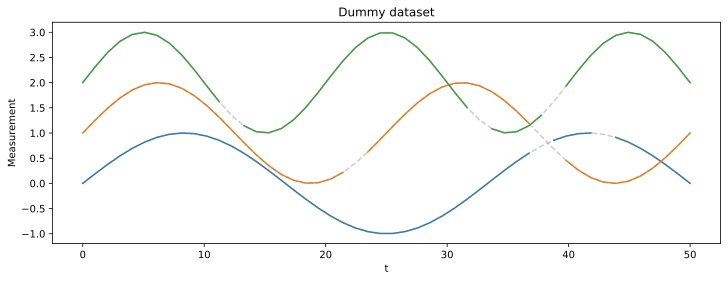

In [93]:
# Plot the dummy dataset
%config InlineBackend.figure_format = 'svg'
plt.figure(figsize=(12,4))
plt.title("Dummy dataset")
plt.xlabel("t")
plt.ylabel("Measurement")
for i in range(3):
    plt.plot(t*50,x[i].cpu())
    plt.plot(t*50,ground_truth[i].cpu(),alpha=0.4,c="grey",linestyle='dashed')

In [4]:
# Forward estimate
hf_t12_d3 = np.array([2,4,3]) # Forward Hidden state of t-1

Wf3 = np.array([[ 0.1546, -0.6600,  0.5753],
        [-0.0077, -0.6195,  0.1414],
        [ 0.2404,  0.1764,  0.7104]]) # 3x3 weight matrix W^1
Vf3 = np.array([[-0.5855, -0.5765,  0.9371],
        [-0.5110,  0.3941,  0.5218],
        [-0.5413,  0.4935, -0.2625]]) # 3x3 weight matrix V^1
cf3 = np.array([-0.9524, -1.1768, -1.0417]) # 3x1 weight matrix V^1

hf_t13_d3 = ReLU(Wf3.dot(hf_t12_d3) + Vf3.dot(np.array([1.6247,1,1])) + cf3) # Calculate result

print(" The forward hidden state of t=13 and d=3 is: ",hf_t13_d3)

 The forward hidden state of t=13 and d=3 is:  [-0.         -0.          1.62744989]


In [5]:
hb_t13_d3 = np.array([-1,1.5,2.75]) # Backward Hidden state of t
U3 = np.array([ 0.2740,  0.6337,  0.8451, -1.1979,  0.4775, -0.4943]) # 1x6 Weight matrix U^1
c_3_0 = np.array([-0.2885]) # 1x1 bias c_0^1

x_tilde_t13_d3 = ReLU(U3.dot(np.concatenate((hf_t13_d3,hb_t13_d3))) + c_3_0) # compute result
print("Intermediate estimate for t=13 and d=3: ", x_tilde_t13_d3)

Intermediate estimate for t=13 and d=3:  [1.6416829]


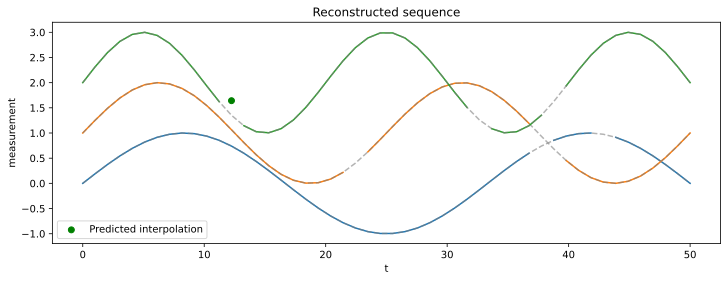

In [12]:
# Dummy dataset output
plt.figure(figsize=(12,4))
plt.title("Reconstructed sequence")
plt.ylabel("measurement")
plt.xlabel("t")
for i in range(3):
    plt.plot(t*50,x[i].cpu())
    plt.plot(t*50,ground_truth[i].cpu(),linestyle="dashed",c="grey",alpha=0.6)
plt.scatter(t[12]*50,x_tilde_t13_d3,c="green",label="Predicted interpolation")
plt.legend()

In [6]:
## Example of imputor

U = np.array([[ 0.0000, -0.5917, -0.4022],
        [ 0.0718,  0.0000,  0.7470],
        [-0.1493,  0.0946,  0.0000]]) # 3x3 weight matrix with 0 on diagonal
V1 = np.array([[-0.4108, -0.4928,  0.0758],
        [ 0.1374,  0.1361, -0.1438],
        [-0.5133, -0.5428, -0.0387]]) # 3x3 weight matrix
V2 = np.array([[-0.2221, -0.6349, -0.4399],
        [ 0.5302, -0.0099, -0.5198],
        [-0.3753, -0.8754, -0.5621]]) # 3x3 weight matrix
beta = np.array([-0.2132,  0.6235, -0.1733]) # 3x1 bias matrix

x_tilde_t13 = np.array((0.125,1.565,x_tilde_t13_d3.item())) # combined intermediate estimates

# compute result
h_13 = ReLU(U.dot(np.array([0.7403,1.0641,1.642])) + V1.dot(x_tilde_t13) + V1.dot(x_tilde_t13) + beta)
print("Imputer hidden state of t=13: ",h_13)

Imputer hidden state of t=13:  [-0.          1.89142254 -0.        ]


In [7]:
W = np.array([[-0.1957, -0.0024, -0.3857],
        [ 0.0047,  0.5593, -0.2730],
        [-0.0396,  0.5180,  0.2218]]) # 3x3 weight matrix
alpha = np.array([ 0.5846, 0.3176,  0.49670]) # 1x1 bias

# compute result
x_hat_13 = W.dot(h_13) + alpha
print("Final output of t=13: ",x_hat_13)

Final output of t=13:  [0.58006059 1.37547263 1.47645687]


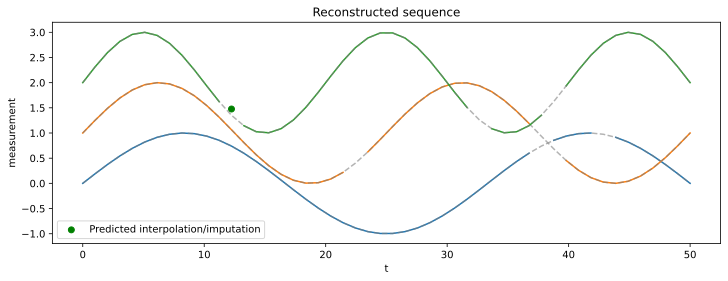

In [15]:
# Dummy dataset output
plt.figure(figsize=(12,4))
plt.title("Reconstructed sequence")
plt.ylabel("measurement")
plt.xlabel("t")
for i in range(3):
    plt.plot(t*50,x[i].cpu())
    plt.plot(t*50,ground_truth[i].cpu(),linestyle="dashed",c="grey",alpha=0.6)
plt.scatter(t[12]*50,x_hat_13[2],c="green",label="Predicted interpolation/imputation")
plt.legend()


## Training on small dataset

In [52]:
class interpolater(nn.Module):
    '''Interpolater Module for the M-RNN model.'''
    def __init__(self,nchannels,hidden_dim,seq_len,padding="replication",act='relu'):
        super(interpolater, self).__init__()
        self.nchannels = nchannels
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        
        # Activation function
        if act == 'relu':
            self.act = F.relu
        elif act == 'tanh':
            self.act = F.tanh
        
        # Forward RNN weights
        self.Wf = Parameter(block_diag(xavier_uniform_(torch.FloatTensor(nchannels,hidden_dim,hidden_dim).to(device=device))))
        self.Vf = Parameter(block_diag(xavier_uniform_(torch.FloatTensor(nchannels,hidden_dim,3).to(device=device))))
        self.cf = Parameter(block_diag(xavier_uniform_(torch.FloatTensor(nchannels,hidden_dim,1).to(device=device))))

        # Backward RNN weights
        self.Wb = Parameter(block_diag(xavier_uniform_(torch.FloatTensor(nchannels,hidden_dim,hidden_dim).to(device=device))))
        self.Vb = Parameter(block_diag(xavier_uniform_(torch.FloatTensor(nchannels,hidden_dim,3).to(device=device))))
        self.cb = Parameter(block_diag(xavier_uniform_(torch.FloatTensor(nchannels,hidden_dim,1).to(device=device))))

        # Hidden state weights (combine forward and backward)
        self.U = Parameter(block_diag(xavier_uniform_(torch.FloatTensor(nchannels,1,hidden_dim*2).to(device=device))))
        self.c0 = Parameter(block_diag(nn.init.normal_(torch.FloatTensor(nchannels,1,1),std=.1).to(device=device)))
        
        # Padding options
        if padding == "replication":
            self.pad = nn.ReplicationPad2d((1,1,0,0))
        elif padding == "zero":
            self.pad = nn.ZeroPad2d((1,1,0,0))
            
    def forward(self,x,m,d):
        '''A forward pass through the interpolater. This function will go through all time steps.
        Input:
        x = Measurement
        m = Mask (1=observed, 0=missing)
        d = time elapsed since last observation
        
        Output:
        Estimate x_est for every input time step.'''
        
        batchsize = x.shape[0]
        # Initialize hidden states
        hidden_forwards = [torch.zeros(batchsize,self.hidden_dim*self.nchannels,self.nchannels)]
        hidden_backwards = [torch.zeros(batchsize,self.hidden_dim*self.nchannels,self.nchannels)]
        
        # Append zeros to beginning and end of input
        x = self.pad(x.unsqueeze(0)).squeeze(0)
        m = self.pad(m.unsqueeze(0)).squeeze(0)
        d = self.pad(d.unsqueeze(0)).squeeze(0)
        
        # Iterate through time (backward and forward)
        for t in range(self.seq_len):  
            # forward RNN hidden states
            hidden_f = self.act(torch.matmul(self.Wf,hidden_forwards[t]) + torch.matmul(self.Vf,
                block_diag(torch.stack((x[:,:,t],m[:,:,t],d[:,:,t]),axis=2).view(-1,self.nchannels,3,1))) 
                +self.cf)
            
            # backward RNN hidden states
            hidden_b = self.act(torch.matmul(self.Wb,hidden_backwards[t]) + 
                  torch.matmul(self.Vb,block_diag(torch.stack((x[:,:,self.seq_len+1-t],m[:,:,self.seq_len+1-t],
                  d[:,:,self.seq_len+1-t]),axis=2).view(-1,self.nchannels,3,1))) 
                  + self.cb)
            
            hidden_forwards.append(hidden_f)
            hidden_backwards.append(hidden_b)

        hidden_forwards = hidden_forwards[1:] # delete state t=-1
        hidden_backwards = hidden_backwards[1:][::-1] # delete state t=T+1 and reverse the list
        
        final_hidden=torch.empty(batchsize,self.nchannels,self.seq_len)
        
        # Iterate through time again and compute combined state
        for t in range(self.seq_len):
            hidden = self.act(torch.matmul(self.U,block_diag(torch.cat((
                unblock_diag(hidden_forwards[t],n=self.nchannels,size_block=(self.hidden_dim,1)),
                unblock_diag(hidden_backwards[t],n=self.nchannels,size_block=(self.hidden_dim,1))),axis=2))) 
                + self.c0)
            
            final_hidden[:,:,t]= unblock_diag(hidden,n=self.nchannels).flatten(1)
            
        return final_hidden
    
class imputer(nn.Module):
    '''Fully connected network that computes the imputation across data streams. We can use the time dimension
    as the batch dimension here, as the linear layers are independent of time.'''
    def __init__(self,n_channels,hidden_dim=3,act='relu'):
        super(imputer, self).__init__()
        if act == 'relu':
            self.act = F.relu
        elif act == 'tanh':
            self.act = F.tanh
        self.V1 = nn.Linear(n_channels,hidden_dim,bias=False)
        self.V2 = nn.Linear(n_channels,hidden_dim,bias=False)
        self.U = nn.Linear(n_channels,hidden_dim) # bias beta
        self.W = nn.Linear(hidden_dim,n_channels) # bias alpha
        
    def forward(self,x,x_est,m):
        '''x : true measurement
        x_est : estimated measurement of the interpolater
        m : mask'''
        v1out = self.V1(x_est.permute(0,2,1))
        v2out = self.V2(m.permute(0,2,1))
        self.U.weight.data.fill_diagonal_(0) # diagonal to zero to prevent usage of x_t^d at for prediction x_hat_t^d
        uout = self.U(x.permute(0,2,1)) 
        h = self.act(uout+v1out+v2out) # hidden layer
        out = self.W(h) # output layer, linear activation here
        return out.permute(0,2,1)
    
class MRNN(nn.Module):
    def __init__(self,nchannels,seq_len,hidden_dim_inter,hidden_dim_imp=3,verbose=False,padding="replication",act='relu'):
        super(MRNN, self).__init__()
        self.inter = interpolater(nchannels,hidden_dim_inter,seq_len,padding=padding,act=act)
        self.imp = imputer(nchannels,hidden_dim_imp,act=act)
        self.verbose = verbose
        
    def forward(self,x,m,d):
        '''x = measurements, m = mask, d = time delta between measurements'''
        out = self.inter.forward(x,m,d)
        out = self.imp.forward(x,out,m)
        return out
    
    def fit(self,epochs,optimizer,loss_func,batch_size,x,m,d):
        loss_hist = []
        # Make initial interpolation
        x = lin_interpolation(x)

        # Iterate over epochs
        pbar = tqdm(range(epochs))
        for i in pbar:   
            # shuffle dataset
            indices = torch.randperm(x.shape[0])
            x = x[indices]
            m = m[indices]
            d = d[indices]
            
            temp_loss_hist=[]
            # Iterate over all batches
            for batch in range(int(x.shape[0] / batch_size)):
                x_b = x[batch*batch_size:(batch+1)*batch_size]
                m_b = m[batch*batch_size:(batch+1)*batch_size]
                d_b = d[batch*batch_size:(batch+1)*batch_size]
                # Estimate all values (forward pass)
                output = self.forward(x_b,m_b,d_b)
                # Compute loss
                loss = loss_func(m_b*output,m_b*x_b) # only use loss of actually observed measurements
                # Backward the loss
                optimizer.zero_grad()
                loss.backward()
                temp_loss_hist.append(loss)
                # Update the weights
                optimizer.step()
            if self.verbose and i%10==0:
                # print graph
                x_hat = self.predict(x,m,d)
                missing = (m!=1)
                live_plot(x_hat[0],missing[0],x[0],title=i)
                
            loss_hist.append(torch.stack(temp_loss_hist).mean())
            pbar.set_postfix({'loss': torch.stack(temp_loss_hist).mean()})
             
        return loss_hist
    
    def predict(self,x,m,d,replace=False):
        with torch.no_grad():
            # initial interpolation
            x = lin_interpolation(x)
            # Forward dataset
            out = self.forward(x,m,d)
            if replace:
                observed = (m==1)
                out[observed] = x[observed]
                
        return out        

In [101]:
# create the model
torch.manual_seed(7)
dummy_model = MRNN(3,50,32,32,verbose=True,act='tanh')
dummy_optimizer = torch.optim.Adam(dummy_model.parameters(),lr=0.06)
loss_func = nn.MSELoss()
epochs = 40

NameError: name 'torch' is not defined

In [55]:
# data preparation before unsqueeze the shape is (3,50), after unsqueeze the shape is (1,3,50)
x_t = x.unsqueeze(0).float().to(device=device)
m_t = mask.unsqueeze(0).float().to(device=device)
d_t = delta.unsqueeze(0).float().to(device=device)



  0%|          | 0/40 [00:00<?, ?it/s]

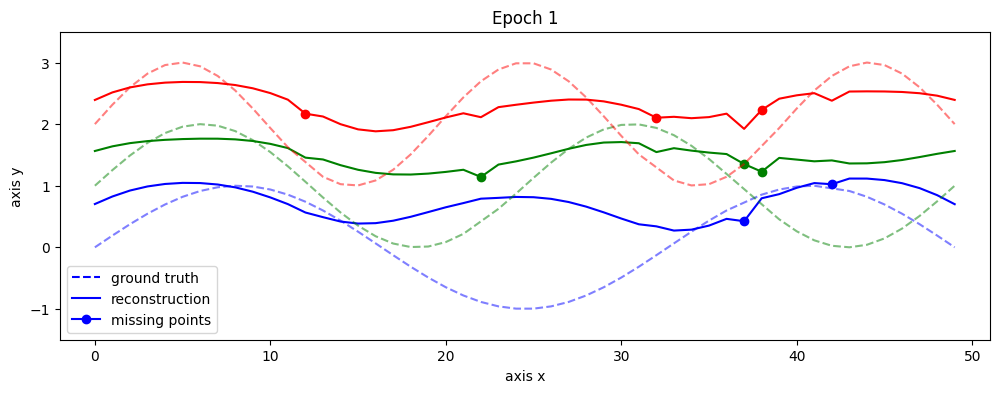

 25%|██▌       | 10/40 [00:03<00:08,  3.51it/s, loss=tensor(0.0963, grad_fn=<MeanBackward0>)]

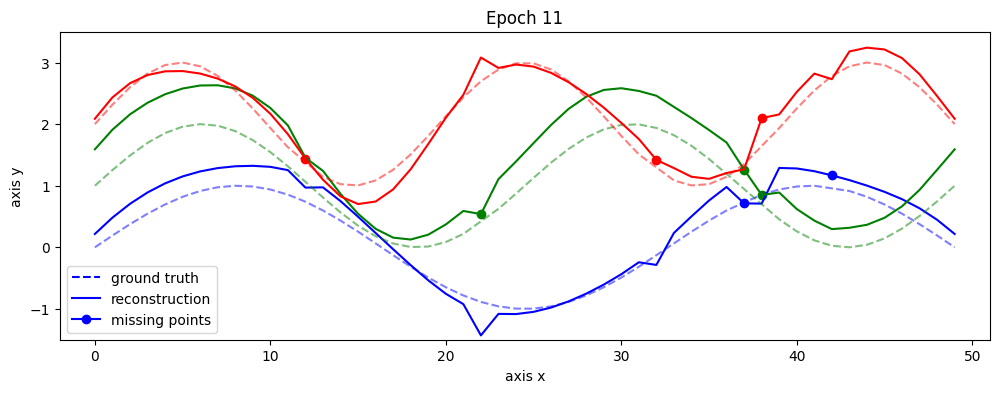

 50%|█████     | 20/40 [00:06<00:05,  3.65it/s, loss=tensor(0.0256, grad_fn=<MeanBackward0>)]

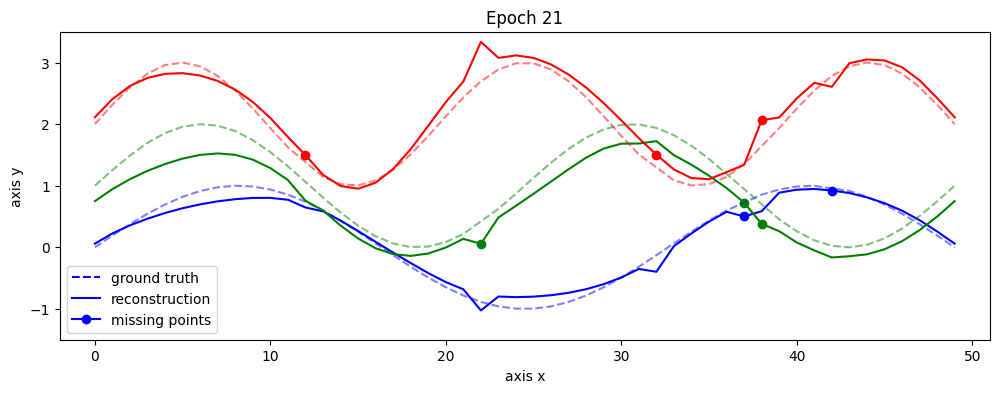

 75%|███████▌  | 30/40 [00:09<00:02,  4.10it/s, loss=tensor(0.0105, grad_fn=<MeanBackward0>)]

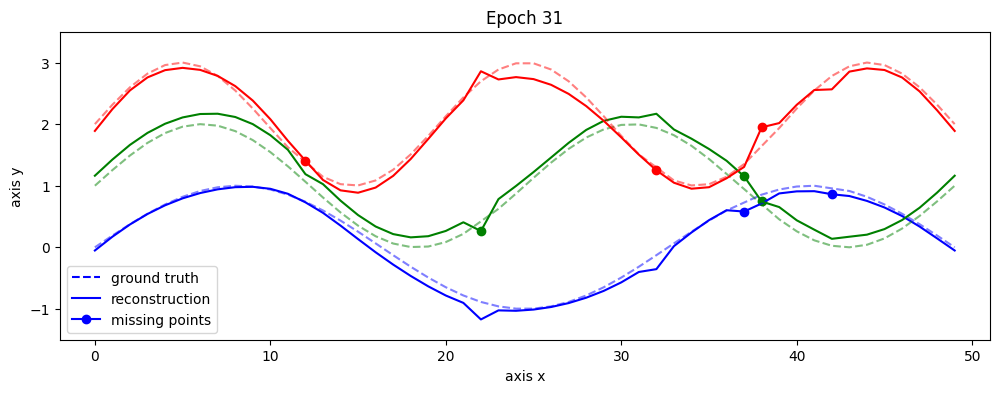

100%|██████████| 40/40 [00:12<00:00,  3.31it/s, loss=tensor(0.0037, grad_fn=<MeanBackward0>)]


In [56]:
losses = dummy_model.fit(epochs,dummy_optimizer,loss_func,1,x_t,m_t,d_t) # start interactive training

## Train on real dataset

In [77]:
import arff

data = arff.load('EEG_Eye_State.arff')

df = pd.DataFrame(data)

df = df.iloc[:,:-1].T
#df.shape is (14,14980)

In [78]:
# Chunk it into sequences
nchunks = 200
chunksize = int(df.shape[1] / nchunks)
chunked=[df.iloc[:,chunksize*i:chunksize*(i+1)] for i in range(nchunks)]
df_chunked = torch.tensor(np.array(chunked)).float()#.cuda() when on GPU

In [79]:
# Lets have a look at the shape
print("Number of samples: ",df_chunked.shape[0])
print("Number of channels: ",df_chunked.shape[1])
print("Length of time sequence: ",df_chunked.shape[2])

Number of samples:  200
Number of channels:  14
Length of time sequence:  74


In [80]:
# lets just use the first 4 channels
df_trained = df_chunked[:,:4,:]


In [81]:
# Prepare mask and delta -> delta is not given in the dataset, hence we will use simple assumptions
mask = torch.ones_like(df_trained).float()
delta = torch.ones_like(df_trained).float()
delta[:,:,0] = 0

In [82]:
# Make a ground truth copy
ground_truth = df_trained.detach().clone()
# remove 5% of the data
np.random.seed(5)
ix = [(row,channel, step) for row in range(df_trained.shape[0]) for channel in range(df_trained.shape[1]) for step in range(df_trained.shape[2])]
np.random.shuffle(ix)
to_replace = int(round(.05*len(ix)))
ix = ix[:to_replace]

for idx in ix:
    df_trained[idx[0],idx[1],idx[2]] = np.nan
    mask[idx[0],idx[1],idx[2]] = 0

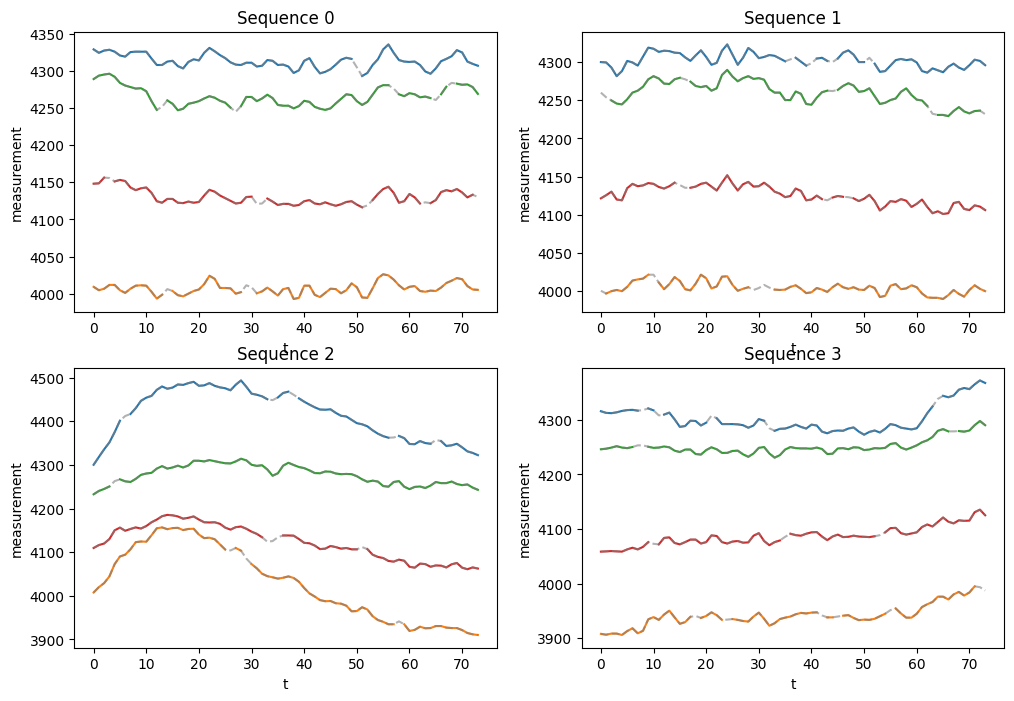

In [83]:
# Plot some sequences
plt.figure(figsize=(12,8))
for pl in range(4):
    plt.subplot(221+pl)
    plt.title("Sequence {}".format(pl))
    plt.xlabel("t")
    plt.ylabel("measurement")
    for dim in range(4):
        plt.plot(np.arange(74),df_trained[pl,dim,:].cpu())
        plt.plot(np.arange(74),ground_truth[pl,dim,:].cpu(),c="grey",linestyle="dashed",alpha=0.6)


In [88]:
eye_model = MRNN(4,74,32,32,verbose=True,padding="replication").to(device=device)
optimizer = torch.optim.Adam(eye_model.parameters(),lr=0.005)
loss_func = nn.MSELoss()
epochs = 51

  0%|          | 0/51 [00:00<?, ?it/s]

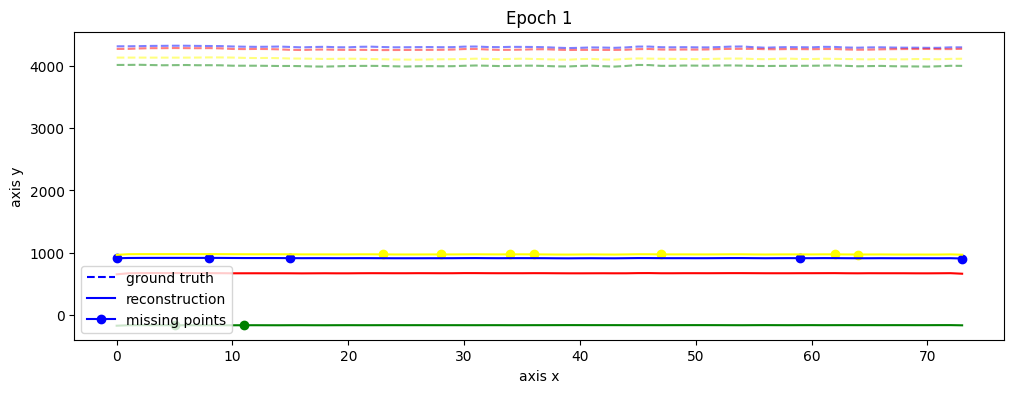

 20%|█▉        | 10/51 [00:21<01:17,  1.90s/it, loss=tensor(4274943.5000, grad_fn=<MeanBackward0>)]

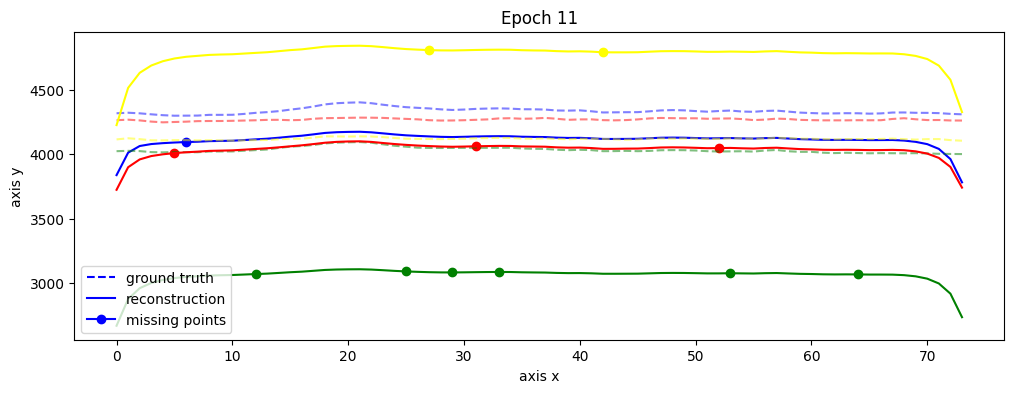

 39%|███▉      | 20/51 [00:42<00:58,  1.89s/it, loss=tensor(807213.7500, grad_fn=<MeanBackward0>)] 

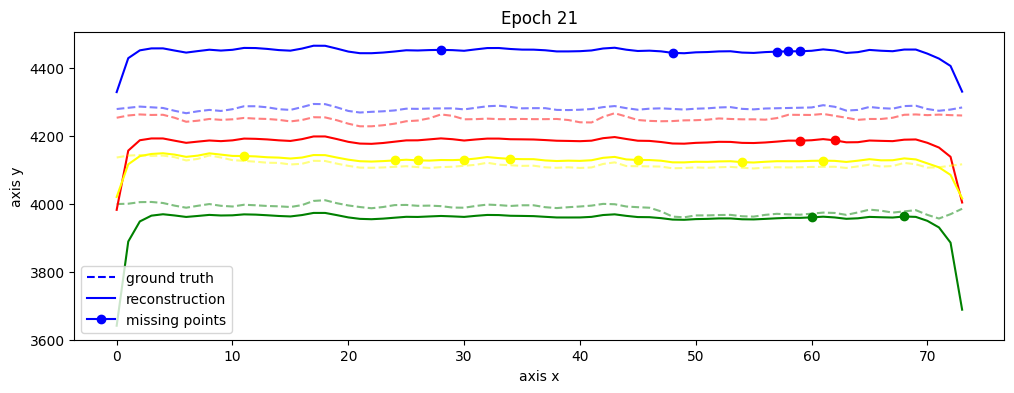

 59%|█████▉    | 30/51 [01:06<00:48,  2.29s/it, loss=tensor(27442.9961, grad_fn=<MeanBackward0>)] 

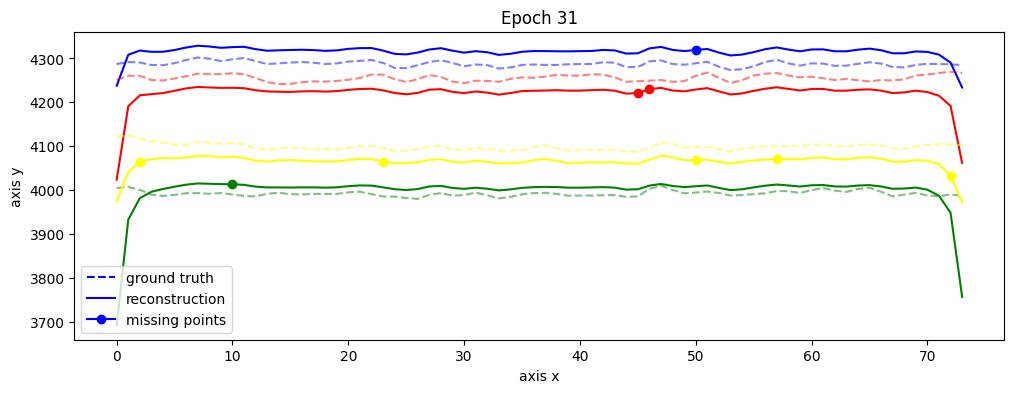

 78%|███████▊  | 40/51 [01:27<00:21,  1.91s/it, loss=tensor(15389.4746, grad_fn=<MeanBackward0>)] 

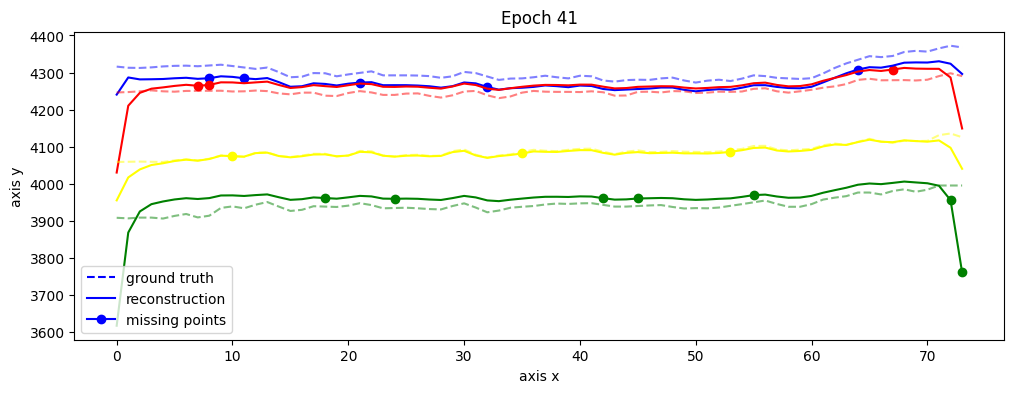

 98%|█████████▊| 50/51 [01:52<00:02,  2.33s/it, loss=tensor(18128.8711, grad_fn=<MeanBackward0>)]

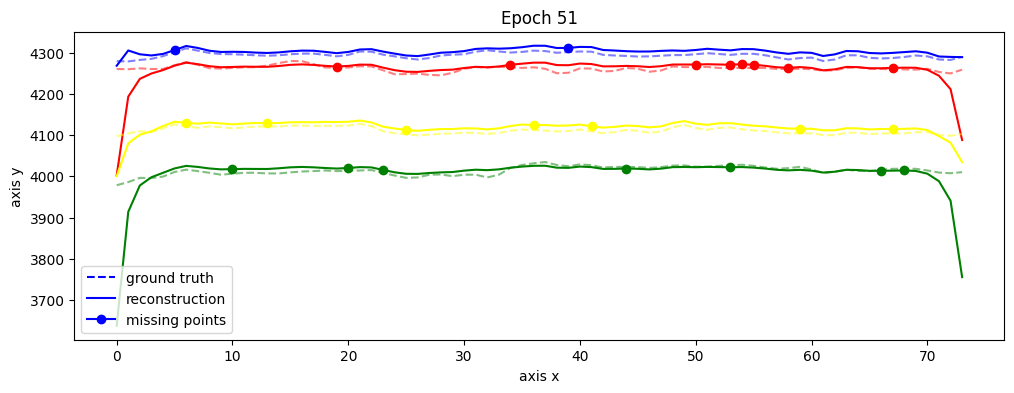

100%|██████████| 51/51 [01:55<00:00,  2.27s/it, loss=tensor(3302.4751, grad_fn=<MeanBackward0>)] 


In [89]:
# Fit the model
losses = eye_model.fit(epochs,optimizer,loss_func,80,df_trained,mask,delta)

In [63]:
predict = eye_model.predict(df_trained,mask,delta,replace=False)



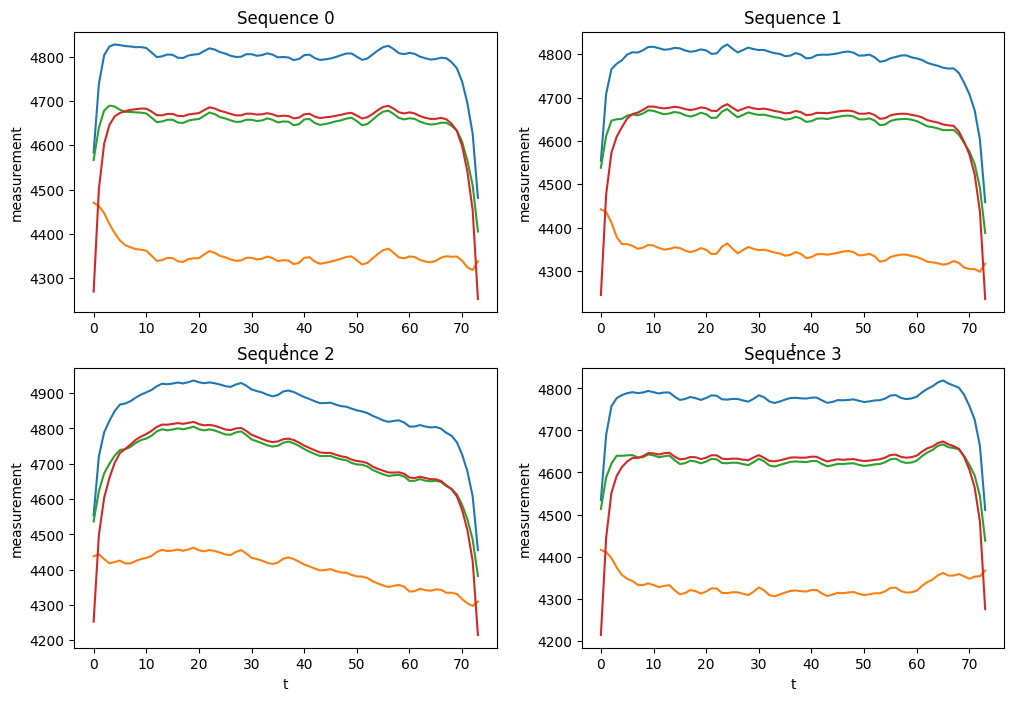

In [64]:
plt.figure(figsize=(12,8))
for pl in range(4):
    plt.subplot(221+pl)
    plt.title("Sequence {}".format(pl))
    plt.xlabel("t")
    plt.ylabel("measurement")
    for dim in range(4):
        plt.plot(np.arange(74),predict[pl,dim,:].cpu())

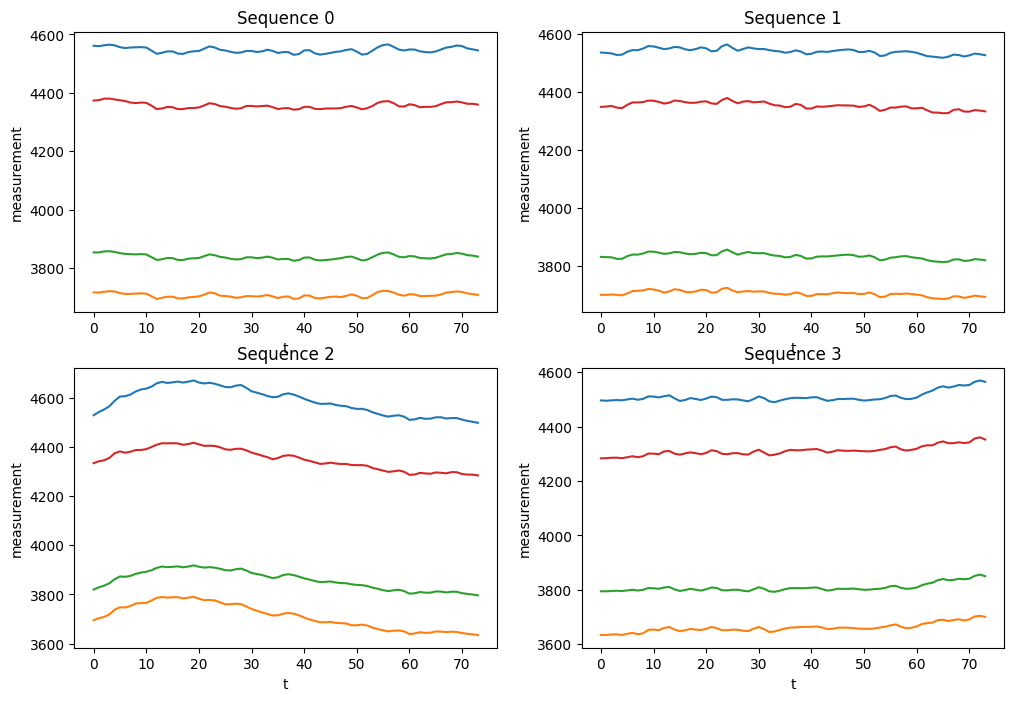

In [87]:
predit = eye_model.predict(df_trained,mask,delta,replace=False)

plt.figure(figsize=(12,8))
for pl in range(4):
    plt.subplot(221+pl)
    plt.title("Sequence {}".format(pl))
    plt.xlabel("t")
    plt.ylabel("measurement")
    for dim in range(4):
        plt.plot(np.arange(74),predit[pl,dim,:].cpu())
        #plt.plot(np.arange(74),ground_truth[pl,dim,:].cpu(),c="grey",linestyle="dashed",alpha=0.6)